# Notebook to read FINN fire emissions

In [1]:
import pandas as pd
import iris.pandas
import iris
import numpy as np
import iris.quickplot as qplt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt


In [69]:
species = 'PM25'

hires = True


# Path the FINN csv file
filepath = '/data/users/bdrummon/FINN/FINNv2.4/2018/MODIS_only/FINNv2.4_MOD_MOZART_2018_c20210617_subset.txt'

# Path to a template NAME file
if hires:
    gridpath = '/data/users/bdrummon/emissions/NAME/nameaq_emissions_2015_v1_regridded_2p2km/gridded_emissions_snap01_201501160000.nc'
else:
    gridpath = '/data/users/pmolina/AQ_Emissions/output/name/2015/std_ukdom_116x122/emep05/no_spread/gridded_emissions_snap01_201501160000.nc'

# Day of year - fire peaked 27th June, which is 178
days = {
    176 : 20180625, 
    177 : 20180626, 
    178 : 20180627,
    179 : 20180628, 
    180 : 20180629,
    181 : 20180630, 
    182 : 20180701, 
    183 : 20180702, 
    184 : 20180703
}

# Basic mask to cutout N England area
lat = (53.2, 54.8)
lon = (-3., -1.0)

# Map NAME species to FINN - mostly just different names for the same species
SPECIES_DICT = {
    'CO' : 'CO',
    'NO' : 'NO',
    'NO2' : 'NO2',
    'SO2' : 'SULPHUR-DIOXIDE',
    'NH3' : 'AMMONIA',
    'PM25' : 'PM25',
    'PMC' : 'PMC',
    'BIGENE' : 'BD', # Big alkenes lumped into 1,3-butadiene
    'C2H4' : 'C2H4',
    'C3H6' : 'C3H6',
    'CH2O' : 'HCHO', 
    'CH3CHO' : 'CH3CHO',
    'ISOP' : 'C5H8',
    'MGLY' : 'MGLYOX',
    'TOLUENE' : 'TOLUEN',
    'XYLENE' : 'OXYL'
}

NAMES = {
    'CO' : 'carbon monoxide',
    'NO' : 'nitrogen monoxide',
    'NO2' : 'nitrogen dioxide',
    'SULPHUR-DIOXIDE' : 'sulphur dioxide',
    'AMMONIA' : 'ammonia',
    'PM25' : 'pm2p5 dry aerosol particles',
    'PMC' : 'pm coarse dry aerosol particles',
    'BD' : '1,3-butadiene',
    'C2H4' : 'ethene',
    'C3H6' : 'propene',
    'HCHO' : 'formaldehyde',
    'CH3CHO' : 'acetaldehyde',
    'C5H8' : 'isoprene',
    'MGLYOX' : 'methyl glyoxal',
    'TOLUEN' : 'toluene',
    'OXYL' : 'o-xylene'
}

limits = {
    'PM25' : (0.8e-7, 2e-7)
}

PLOTDIR = '/home/h01/bdrummon/plots/Saddleworth_Moor/FINN/'

# Setup the map
mapstyle='street'
bkmap = cimgt.GoogleTiles(style=mapstyle)

In [25]:
molar_masses = {
    ' APIN' : 136.23,
    'BENZENE' : 78.11,
    'BIGALK' : 72.151,
    'BIGENE' : 56.108, 
    'BPIN' : 136.238,
    'BZALD' : 106.124,
    'C2H2' : 26.038,
    'C2H4' : 28.051,
    'C2H6' : 30.070,
    'C3H6' : 42.081,
    'C3H8' : 44.097,
    'CH2O' : 30.026,
    'CH3CH2OH' : 46.069,
    'CH3CHO' : 44.053,
    'CH3CN' : 41.053,
    'CH3COCH3' : 58.080,
    'CH3COOH' : 60.052,
    'CH3OH' : 32.04,
    'CRESOL' : 108.13,
    'GLYALD' : 60.052,
    'HCN' : 27.0253,
    'HCOOH' : 46.025,
    'HONO' : 47.013,
    'HYAC' : 74.079,
    'ISOP' : 68.12,
    'LIMON' : 136.238,
    'MACR' : 70.09,
    'MEK' : 72.107,
    'MGLY' : 72.063,
    'MVK' : 70.09,
    'MYRC' : 136.238,
    'PHENOL' : 94.113,
    'TOLUENE' : 92.141,
    'XYLENE' : 106.168,
    'XYLOL' : 122.167,
    'CO' : 28.01,
    'NO' : 30.01,
    'NO2' : 46.0055,
    'SO2' : 64.066,
    'NH3' : 17.031
}


In [4]:
#Load FINN data
df = pd.read_csv(filepath, index_col=False)
df

,Unnamed: 0,DAY,POLYID,FIREID,GENVEG,LATI,LONGI,AREA,BMASS,CO2,...,LIMON,MACR,MEK,MGLY,MVK,MYRC,PHENOL,TOLUENE,XYLENE,XYLOL
0,3812659,176,1523636,2408370,1,53.502,-2.002,1404000.0,1.099,59090000.0,...,0.0,0.0,16090.0,15090.0,13790.0,0.000,20530.0,19870.0,16740.0,4697.0
1,3815071,176,1523636,2408379,4,53.514,-1.990,18290.0,1.124,705400.0,...,181.9,130.1,315.4,155.4,284.3,2.302,397.1,696.4,485.7,101.3
2,3815072,176,1523636,2408379,1,53.514,-1.990,896100.0,1.124,38590000.0,...,0.0,0.0,10510.0,9856.0,9003.0,0.000,13410.0,12980.0,10930.0,3067.0
3,3818517,176,1523636,2408378,1,53.505,-1.986,807200.0,1.133,35050000.0,...,0.0,0.0,9544.0,8951.0,8177.0,0.000,12180.0,11790.0,9931.0,2786.0
4,3819555,176,1523636,2408372,1,53.507,-1.973,807800.0,1.110,34370000.0,...,0.0,0.0,9358.0,8777.0,8018.0,0.000,11940.0,11560.0,9738.0,2732.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,3992517,183,1600967,2523765,1,53.560,-2.009,832900.0,1.081,34490000.0,...,0.0,0.0,9393.0,8809.0,8047.0,0.000,11980.0,11600.0,9773.0,2742.0
111,3993942,183,1600952,2518377,1,53.617,-2.478,329600.0,1.116,14100000.0,...,0.0,0.0,3839.0,3601.0,3289.0,0.000,4898.0,4742.0,3995.0,1121.0
112,3993943,183,1600952,2518377,1,53.617,-2.478,1162000.0,1.116,49720000.0,...,0.0,0.0,13540.0,12700.0,11600.0,0.000,17270.0,16720.0,14090.0,3952.0
113,4024132,184,1614001,2535644,1,53.617,-2.525,1040000.0,1.160,46220000.0,...,0.0,0.0,12590.0,11800.0,10780.0,0.000,16060.0,15550.0,13100.0,3674.0


In [70]:
# Load template emissions cube
cube = iris.load(gridpath)[0]
cube

<iris 'Cube' of tendency of atmosphere mass content of o-xylene due to emission from SNAP sector 01 / (kg m-2 s-1) (emissions layer number: 7; latitude: 634; longitude: 606)>

In [6]:
# Subet the dataframe to give a specific day (by day number) and between latitude and longitude limits
# Returns another dataframe
def subset_df(df, day):
    # Subset by day and area
    df_day = df[df['DAY']==day]
    df_area = df_day[df['LATI'] < lat[1]]
    df_area = df_area[df['LATI'] > lat[0]]
    df_area = df_area[df['LONGI'] < lon[1]]
    df_area = df_area[df['LONGI'] > lon[0]]

    return(df_area)

In [32]:
# Put the fires into a grid - converting into per unit area
# Put fires into nearest cell
def grid_fires(df, cube, sp):
    # Create new cube using copy of template
    newcube = cube.copy()
    newcube.data = np.zeros(newcube.data.shape)

    gridlats = newcube.coord('latitude').points
    gridlons = newcube.coord('longitude').points

    # Loop over rows and assign each row to a cell in grid 
    # Emissions go into the nearest grid cell
    # This is additive - if multiple pixel fall within a cell
    for index, row in df.iterrows():
        firelat = row['LATI']
        firelon = row ['LONGI']

        idlat = (np.abs(gridlats - firelat)).argmin()
        idlon = (np.abs(gridlons - firelon)).argmin()

        # Convert to emission per unit area - now in kg or mole per day per m2
        # Fire emissions go into lowest level
        # Special case for PMC (coarse fraction of PM)
        # Need to calculate first from PM2.5 and PM10 : PMC = PM10 - PM2.5
        if sp == 'PMC':
            finn = row['PM10'] - row['PM25']
        else:
            finn = row[sp]
        
        newcube.data[0, idlat, idlon] =+ finn/row['AREA']
        
    # Convert units from mole/m2/day -> kg/m2/s
    newcube.data = newcube.data/24./60./60.

    # Gas only
    if sp not in ['PM25', 'PMC']:
        newcube.data = newcube.data*molar_masses[sp] * 1e-3
    
    # Update metadata
    newcube.attributes['tracer_name'] = SPECIES_DICT[sp]
    newcube.long_name = 'tendency of atmosphere mass content of '+NAMES[SPECIES_DICT[sp]]+' due to emission'
    newcube.var_name = SPECIES_DICT[sp]
    newcube.standard_name = None
    newcube.attributes['emiss_sector'] = 'snap11'
    newcube.attributes['source'] = 'FINN v2.4 MOZART-T1 speciation - Fire INventory from NCAR'
    newcube.attributes['title'] = 'NAME emissions generated from FINN database'
    newcube.attributes.pop('daily_scaling', None)
    newcube.attributes.pop('hourly_scaling', None)
    newcube.attributes.pop('vertical_scaling', None)
        
    return(newcube)

In [56]:
# Script to plot fires with background map
def plot_fires(cube, df):

    # Replace zero with nans for plotting
    cube_nan = cube.copy()
    cube_nan.data[cube_nan.data == 0] = np.nan
    
    # Add FiNN pixels
    lats = []
    lons = []
    for index, row in df.iterrows():
        lats.append(row['LATI'])
        lons.append(row['LONGI'])    

    fig=plt.figure(figsize=(12,8), dpi= 100)
    ax = plt.axes(projection=bkmap.crs)
    ax.set_extent([-2.65,-1.85,53.35,53.75], ccrs.PlateCarree())
    qplt.pcolormesh(cube_nan[0], cmap='inferno', alpha=0.8, vmin = limits[species][0], vmax=limits[species][1])
    
    # Add fire pixels
    plt.scatter(np.asarray(lons), np.asarray(lats), marker='*', transform=ccrs.PlateCarree())
    
    # Add background map
    ax.add_image(bkmap, 10, interpolation='spline36')

In [72]:
# Controlling script to make plots
for day in days:
    df_ss = subset_df(df, day)
    fires = grid_fires(df_ss, cube, species)
    plot_fires(fires, df_ss)
    plt.title('PM2.5 emissions, day: '+ str(day))
    plt.savefig(PLOTDIR+'pm25_emission_hires_day'+str(day)+'.png', dpi=150)
    plt.clf()
    #plt.show()
    #plt.clf()
    

/opt/scitools/environments/default/current/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/scitools/environments/default/current/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/scitools/environments/default/current/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/scitools/environments/default/current/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/scitools/environments/default/current/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/scitools/environments/default/current/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be rein

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

## Generate NAME emission files


In [67]:
# Loop over days
for day in days:
    
    # Get current day
    df_ss = subset_df(df, day)
    
    cubelist = iris.cube.CubeList([])
    
    # Put data onto a grid and create cube
    for sp in SPECIES_DICT:
        
        fires = grid_fires(df_ss, cube, sp)
        
        # Update time
        fires.coord('time').convert_units("days since 2018-01-01")
        fires.coord('time').points = np.asarray(day)

        cubelist.append(fires)
    
    if hires:
        subdir = '2p2km'
    else:
        subdir = '12km'
        
    iris.save(cubelist, 
              '/data/users/bdrummon/emissions/NAME/FINNv2.4_Saddleworth_Moor/'+subdir+'/'+str(day)+'_wildfire_emissions.nc')

/opt/scitools/environments/default/current/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/scitools/environments/default/current/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/scitools/environments/default/current/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/scitools/environments/default/current/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/scitools/environments/default/current/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/scitools/environments/default/current/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be rein

## Calculate NMOC scaling factor
Derive from that converts NMOC emissions (kg/day) to species emissions (kg/day)

25580.0
47440.0
30511.173683000005
32340.0
1.0
CH3COOH 0.14238674582560298
BZALD 0.0839409993815708
BIGENE 0.08230561286332715
C2H2 0.054757092764378484
CH3OH 0.046494656771799626
CH2O 0.0460045856524428
CH3CHO 0.04568761966604823
PHENOL 0.0444082987012987
TOLUENE 0.04211020346320347
XYLENE 0.040871725417439705
C2H4 0.03416601391465677
C3H6 0.027221228200371057
MEK 0.026688954545454547
C2H6 0.025830074211502782
MGLY 0.025001448979591837
GLYALD 0.023415452071737786
HYAC 0.022890273562152133
MVK 0.022214672232529376
HCN 0.015108763883735313
HONO 0.014010862523191094
XYLOL 0.013195093722943724
CH3COCH3 0.01167526530612245
BIGALK 0.011255466759431046
BENZENE 0.011247936611008041
HCOOH 0.009481093073593072
CRESOL 0.006379469387755102
CH3CN 0.004803480272108843
ISOP 0.0047014174397031535
C3H8 0.003969275417439703
 APIN 0.0012262384972170687
MYRC 0.0
MACR 0.0
LIMON 0.0
CH3CH2OH 0.0
BPIN 0.0
0.9434500211193569


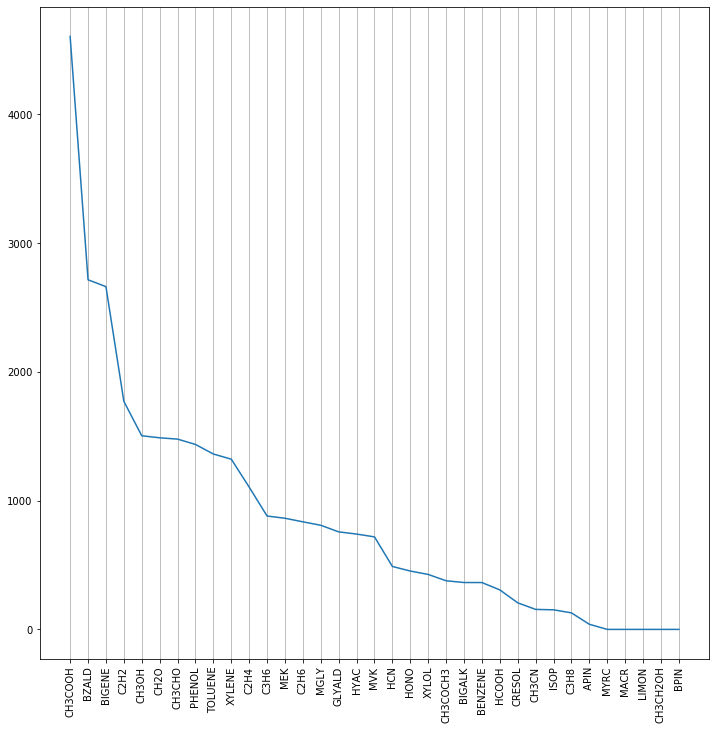

In [9]:
# Plot specieated mass emissions for a cell
# Pick a row
row = df.iloc[15]

print(row['BZALD'])
print(row['BIGENE'])

# Convert to kg/day
mass_emissions = []
for species in molar_masses:
    mass_emissions.append(row[species]*molar_masses[species]*1e-3)
mass_emissions = np.asarray(mass_emissions)

# Sort by emission rate
zipped = zip(list(molar_masses.keys()), mass_emissions.tolist())
sort = sorted(zipped, key=lambda y: y[1])
names = []
emissions = []
for item in sort:
    names.append(item[0])
    emissions.append(item[1])
names = names[::-1]
emissions = emissions[::-1]


# Plot
plt.figure(figsize=(12,12))
x = np.arange(len(names))
plt.xticks(x, names, rotation='vertical')
plt.plot(x, emissions)
ax = plt.gca()
ax.xaxis.grid(True)

print(mass_emissions.sum())
print(row['NMOC'])
print(row['GENVEG'])
total = 0
for name, emission in zip(names, emissions):
    total += emission/row['NMOC']
    print(name, emission/row['NMOC'])
print(total)